# Parameterbestimmung aus Kurzschlusstest

## Initialisierung und erste Schritte

Zunächst müssen wir alles initialisieren. Außerdem muss die Messdatei eingelesen werden. Warnungen werden ignoriert.

In [1]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

csv_file = '10PRCT.csv'
csv_header_size = 11
csv_columns_to_read = ['Time[s]', 'CH3[A]']

df = pd.read_csv(csv_file, header=csv_header_size, sep=';', usecols=csv_columns_to_read)

Mal schauen was wir eingelesen haben:


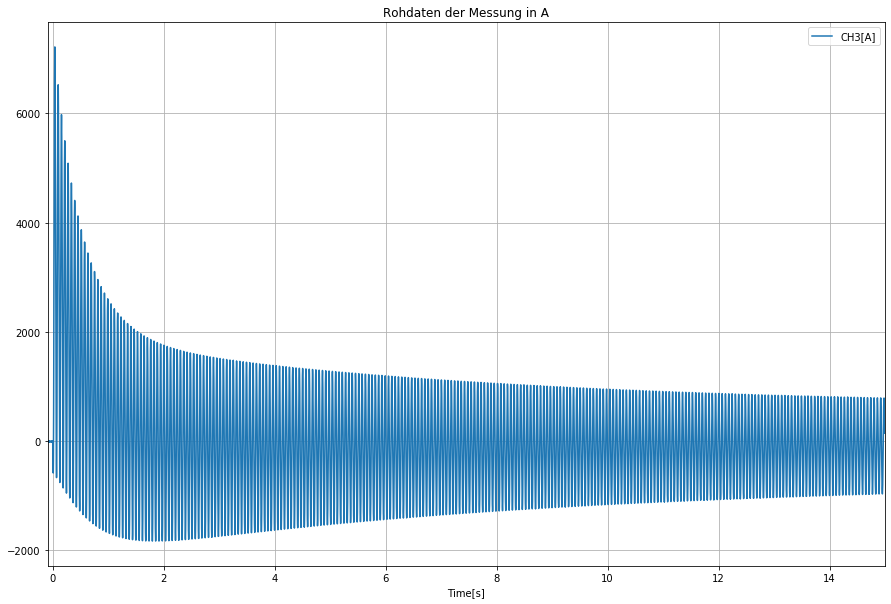

In [2]:
ax = df.plot.line(x='Time[s]', y=['CH3[A]'], title='Rohdaten der Messung in A', figsize=(15,10))
ax.grid('on')

Dies lässt sich auch in p.u. darstellen. Da die Messung aber mit reduzierter Spannung durchgeführt wurde, muss auch der Bezugsstrom entsprechend reduziert werden. I_n wurde aus dem Versuchsprotokoll übernommen.

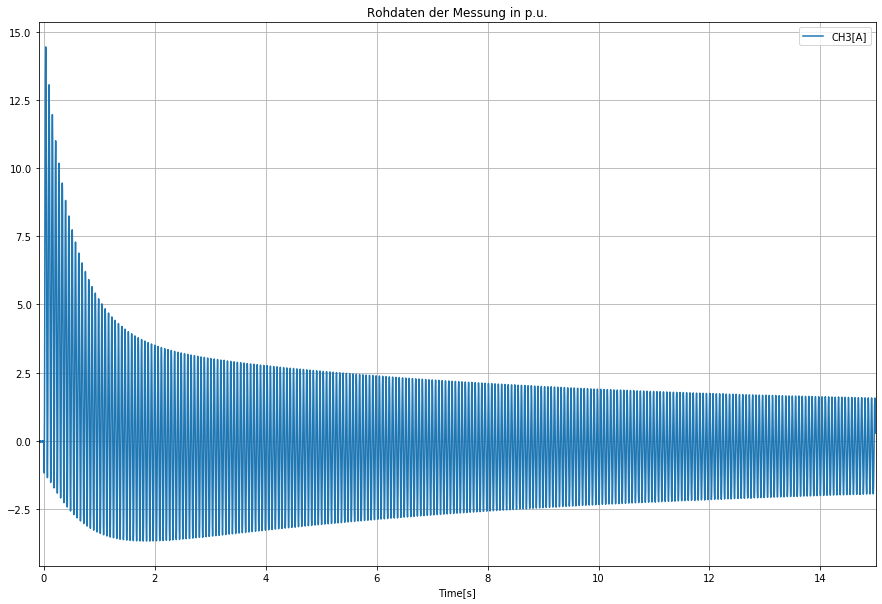

In [3]:
I_n = 499.9 #A rms
df['CH3[A]'] = df['CH3[A]'] / I_n

ax = df.plot.line(x='Time[s]', y=['CH3[A]'], title='Rohdaten der Messung in p.u.', figsize=(15,10))
ax.grid('on')

Der Kurzschluss wurde zum Zeitpunkt 0 eingelegt. Wir entfernen also alle Punkte vor 0.

In [4]:
triggerline = df.loc[df['Time[s]'] == 0].index.values.astype(int)[0]
df = df.iloc[triggerline:,]

Es folgt die Funktion um die Einhüllenden zu bestimmen und deren Anwendung.

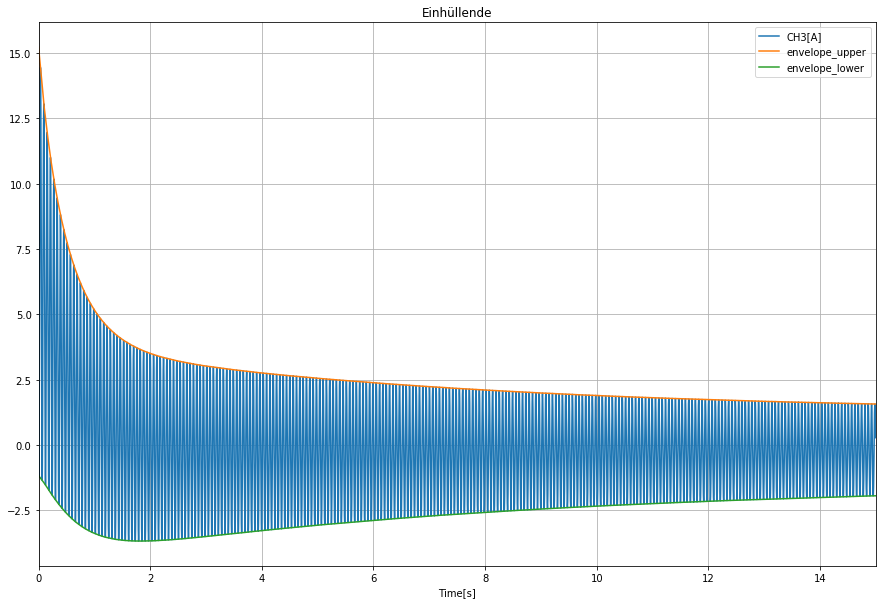

In [5]:
# Die Funktion findet die Maxima bzw. Minima eines Signals s. Es müssen n
# Elemente vor und nach einem Wert kleiner sein. Wenn lower=True, dann müssen
# diese Elemente größer sein.
def envelope(s, n = 4, lower = False):
    u_x = [] # do not add 0
    u_y = []
    q_u = np.zeros(s.shape)
    # durchsuche alle Elemente aus s
    for k in range(1,len(s)-1):
        # Betrachte n Elemente vor und nach dem aktuellen Element k
        for l in range(-n, n+1):
            if (l == 0):
                # das aktuelle Element k brauchen wir nicht betrachten
                continue
            if (lower == False):
                if (np.sign(s[k]-s[k+l])>=0):
                    if (l == n):
                        # Wenn wir die Schleife bis zum Ende überstehen, haben wir ein Maxima gefunden!
                        u_x.append(k)
                        u_y.append(s[k])
                else:
                    break
            if (lower == True):
                if (np.sign(s[k]-s[k+l])<=0):
                    if (l == n):
                        # Wenn wir die Schleife bis zum Ende überstehen, haben wir ein Maxima gefunden!
                        u_x.append(k)
                        u_y.append(s[k])
                else:
                    break
    u_p = interp1d(u_x,u_y, kind = 'slinear',
              bounds_error = False, fill_value = 'extrapolate')
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
    return q_u
df['envelope_upper'] = envelope(df['CH3[A]'].values, 4)
df['envelope_lower'] = envelope(df['CH3[A]'].values, 4, True)

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 'envelope_upper', 'envelope_lower'], title='Einhüllende', figsize=(15,10))
ax.grid('on')

Aus den Einhüllenden lassen sich nun der periodische und aperiosche Verlauf nach Norm berechnen.

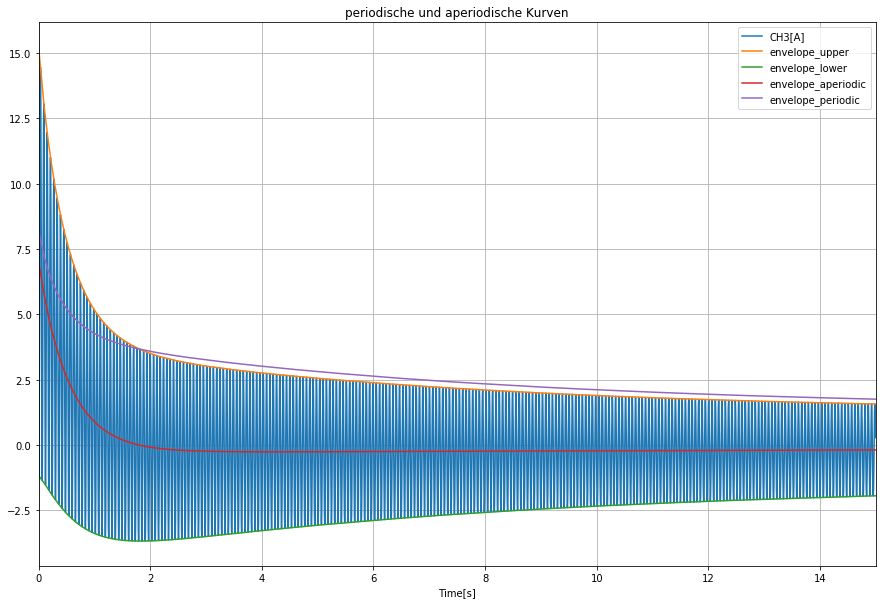

In [6]:
df['envelope_aperiodic'] = ((df['envelope_upper'] + df['envelope_lower']) / 2)
df['envelope_periodic'] = ((df['envelope_upper'] - df['envelope_lower']) / 2)

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'envelope_aperiodic', 
                                  'envelope_periodic'], title='periodische und aperiodische Kurven', figsize=(15,10))
ax.grid('on')

Man erkennt, dass der periodische Anteil ab Sekunde 2 nicht exakt mit der oberen Einhüllenden übereinander liegt. Dies liegt daran, dass auch nach Sekunde 2 ein DC-Offset im aperiodischen Teil der Kurve enthalten und nicht auf 0 abgeklungen ist.

Nun muss aus dem aperiodischen Verlauf noch der konstante Kurzschlussstrom abgezogen werden. Dieser stammt erneut aus dem Versuchsprotokoll.

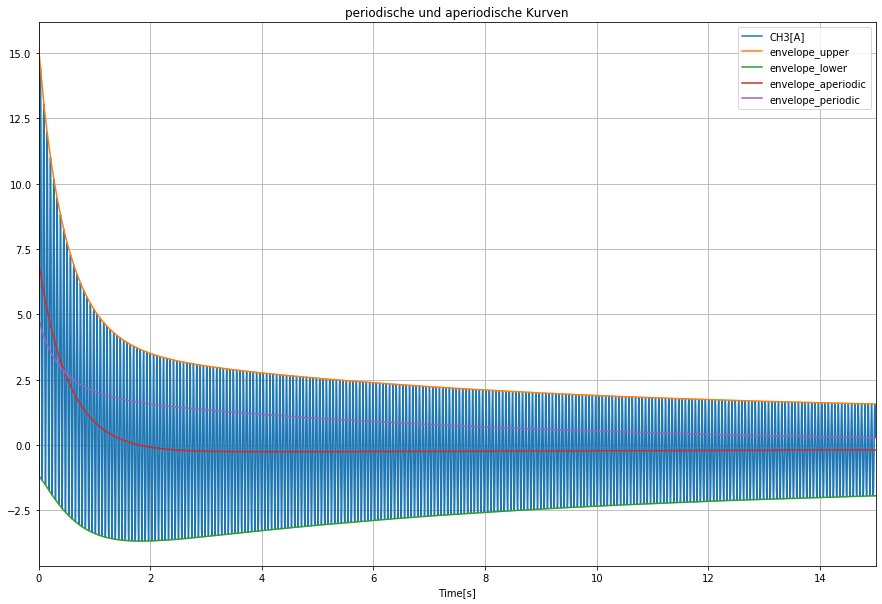

In [7]:
i_inf = 481 #A rms
i_inf = i_inf / I_n #p.u.
df['envelope_periodic'] = df['envelope_periodic'] /np.sqrt(2) - i_inf

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'envelope_aperiodic', 
                                  'envelope_periodic'], title='periodische und aperiodische Kurven', figsize=(15,10))
ax.grid('on')

## Bestimmung der transienten und subtransienten Zeitkonstanten

Aus dem periodischen Verlauf können nun die transienten (xd' und Td') und subtransienten Konstanten (xd'' und Td'') bestimmt werden. Dabei muss mit der Bestimmung der transienten Konstanten begonnen werden. Hierzu entfernen wir alle Messdaten vor Sekunde 4,5.

In [8]:
startpoint = df.index[df['Time[s]'] == 4.5].astype(int)[0]
df_transient = df.iloc[-(len(df['Time[s]'].values)-startpoint+df.index[0]):].copy(deep=True)

Die Verläufe sind näherungsweise Exponentialfunktionen. Um später ein Curve fitting anwenden zu können, müssen wir diese Funktion zunächst definieren.

In [9]:
def myExpFunc(x, a, b):
    return a * np.exp(b * x)

Im Anschluss können wir diese nun anwenden und ploten

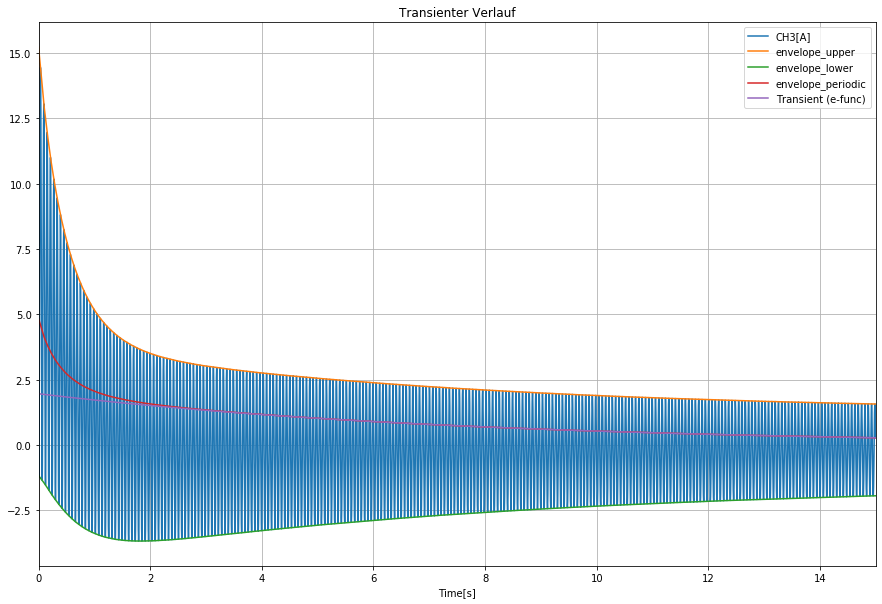

In [10]:
popt_transient, pcov_transient = curve_fit(myExpFunc, df_transient['Time[s]'], df_transient['envelope_periodic'])

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'envelope_periodic'], title='Transienter Verlauf', figsize=(15,10))
ax.plot(df['Time[s]'], myExpFunc(df['Time[s]'], *popt_transient), label='Transient (e-func)')
ax.grid('on')
ax.legend()

Wenn wir nun die e-Funktion des transienten Verlaufes vom periodischen Verlauf abziehen, können wir den subtransienten Verlauf bestimmen.

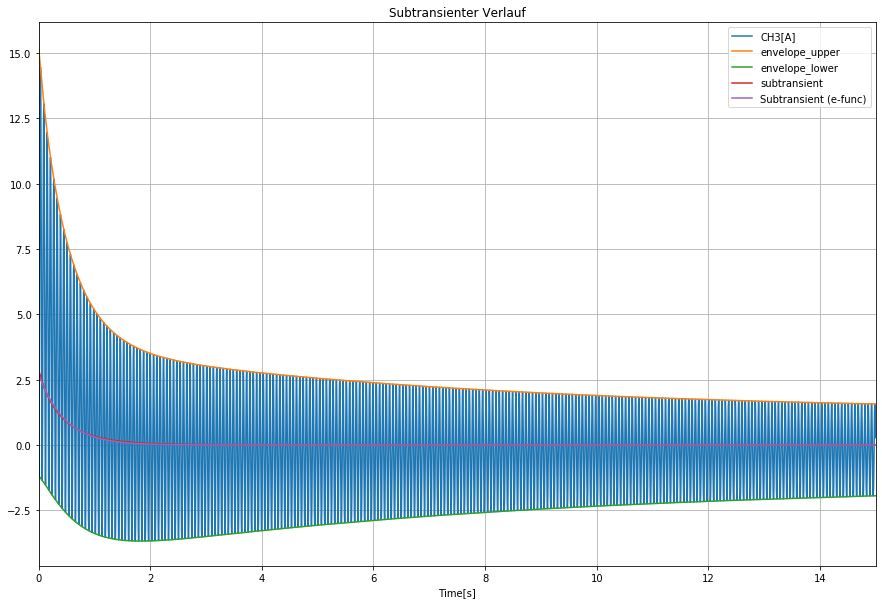

In [11]:
df['subtransient'] = df['envelope_periodic'] - myExpFunc(df['Time[s]'], *popt_transient)

popt_subtransient, pcov_subtransient = curve_fit(myExpFunc, df['Time[s]'], df['subtransient'])

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'subtransient'], title='Subtransienter Verlauf', figsize=(15,10))
ax.plot(df['Time[s]'], myExpFunc(df['Time[s]'], *popt_subtransient), label='Subtransient (e-func)')
ax.grid('on')
ax.legend()

Aus dem negativen Kehrwert der exponentiellen Steigung lassen sich nun die Zeitkonstanten Td' und Td'' bestimmen. Außerdem können wir die Ströme zum Zeitpunkt t=0 bestimmen.

In [12]:
Td_i = -1/popt_transient[1]
di_i = myExpFunc(0, *popt_transient)
Td_ii = -1/popt_subtransient[1]
di_ii = myExpFunc(0, *popt_subtransient)

print("Td':      {} s".format(Td_i))
print("Δi'(t0):  {} p.u.".format(di_i))
print("Td'':     {} s".format(Td_ii))
print("Δi''(t0): {} p.u.".format(di_ii))

Td':      7.68767563886125 s
Δi'(t0):  1.9626287167430965 p.u.
Td'':     0.4610429588914646 s
Δi''(t0): 2.722769788745133 p.u.


Mithilfe dieser Ströme zum Zeitpunkt t=0 und dem xd aus dem Versuchprotokoll, können wir xd' und xd'' bestimmen. Die Formel lautet $\Delta i' = \left( \frac{1}{xd'} - \frac{1}{xd} \right) e^{-\frac{t}{Td'}}$ bzw. $\Delta i'' = \left( \frac{1}{xd''} - \frac{1}{xd'} \right) e^{-\frac{t}{Td''}}$ und lässt sich wie folgt umformen.

In [13]:
xd = 1.179 #p.u.
xd_i = 1/(di_i + 1/xd)
xd_ii = 1/(di_ii + 1/xd_i)
print("xd':      {} p.u.".format(xd_i))
print("xd'':     {} p.u.".format(xd_ii))

xd':      0.35576994885930396 p.u.
xd'':     0.1807150013038057 p.u.


## Bestimmung der "magischen" Zeitkonstante und der Ankerzeitkonstante

Laut Norm lässt sich aus dem aperiodischen Verlauf die Ankerzeitkonstante Ta bestimmen. **Bei einer einphasigen Synchronmashine ändert der Verlauf jedoch zunächst sein Vorzeichen, bevor dieser auf 0 zurück geht. Warum ist dies so? Wenn wir davon ausgehen, dass der zweite Teil des Verlaufes ebenfalls eine e-Funktion ist können wir diese auch bestimmen.**

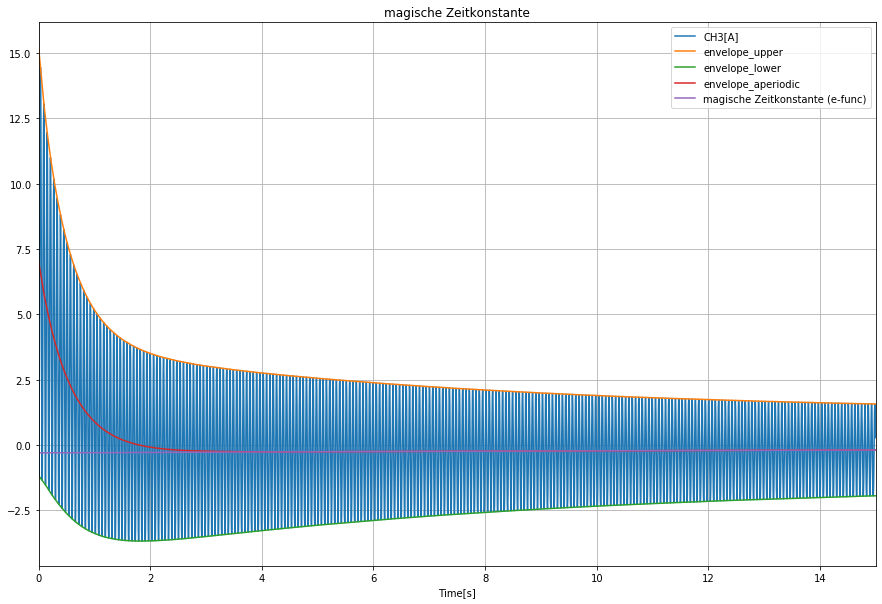

In [14]:
popt_magic, pcov_magic = curve_fit(myExpFunc, df_transient['Time[s]'], df_transient['envelope_aperiodic'])

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'envelope_aperiodic'], title='magische Zeitkonstante', figsize=(15,10))
ax.plot(df['Time[s]'], myExpFunc(df['Time[s]'], *popt_magic), label='magische Zeitkonstante (e-func)')
ax.grid('on')
ax.legend()

Wir können nun diesen Verlauf vom aperiodischen Verlauf abziehen. Hieraus können wir die Ankerzeitkonstante bestimmen.

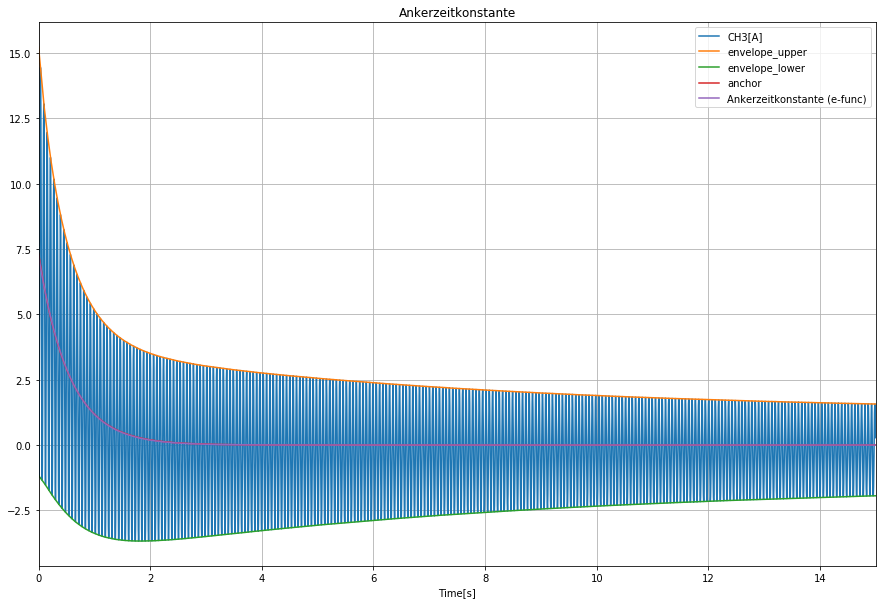

In [15]:
df['anchor'] = df['envelope_aperiodic'] - myExpFunc(df['Time[s]'], *popt_magic)

popt_anchor, pcov_anchor = curve_fit(myExpFunc, df['Time[s]'], df['anchor'])

ax = df.plot.line(x='Time[s]', y=['CH3[A]', 
                                  'envelope_upper', 
                                  'envelope_lower', 
                                  'anchor'], title='Ankerzeitkonstante', figsize=(15,10))
ax.plot(df['Time[s]'], myExpFunc(df['Time[s]'], *popt_anchor), label='Ankerzeitkonstante (e-func)')
ax.grid('on')
ax.legend()

Es ergeben sich somit folgende Konstanten:

In [16]:
T_ = -1/popt_magic[1]
di_ = myExpFunc(0, *popt_magic)
Ta = -1/popt_anchor[1]
dia = myExpFunc(0, *popt_anchor)

print("T?:       {} s".format(T_))
print("Δi?(t0):  {} p.u.".format(di_))
print("Ta:       {} s".format(Ta))
print("Δia(t0):  {} p.u.".format(dia))

T?:       32.60464618242065 s
Δi?(t0):  -0.2986863472101068 p.u.
Ta:       0.5495080110989995 s
Δia(t0):  7.254871256729111 p.u.


## Zusammenfassung und Bestimmung von Td0'

In [17]:
print("Td':      {} s".format(Td_i))
print("xd':      {} p.u.".format(xd_i))
print("Td'':     {} s".format(Td_ii))
print("xd'':     {} p.u.".format(xd_ii))
print("")
print("T?:       {} s".format(T_))
print("Ta:       {} s".format(Ta))
print("")

Td0_i = Td_i*xd/xd_i
print("Td0':     {} s".format(Td0_i))

Td':      7.68767563886125 s
xd':      0.35576994885930396 p.u.
Td'':     0.4610429588914646 s
xd'':     0.1807150013038057 p.u.

T?:       32.60464618242065 s
Ta:       0.5495080110989995 s

Td0':     25.47649009501321 s
